# Bootstrap Your Own Latent (BYOL)
## By: Karim Zakir
BYOL is a representation learning method. The idea behind this method is that the same image with two different augmentations has the same "essence" and thus should have the same or similar embeddings. This method was originally published in [this paper](https://arxiv.org/abs/2006.07733v3) in January 2020. 

Contrastive learning is a deep learning technique in which we try to learn representations of different objects with the goal that embeddings of similar objects will also be similar. Most contrastive learning architectures/methods require "negative pairs", which make constrastive learning computationally expensive. Unlike those methods, BYOL does not require negative pairs, so it's a lot more efficient!
 
In BYOL, we start off by taking an image and applying two different augmentations on it ($t$ and $t'$). These two images are fed to two different networks called online and target. Let's first focus on the online network. After applying augmentation $t$ on a given image, we feed it into the first part of the online network, which is an encoder, which could be any network that transforms an image to features. frf

In [24]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from copy import deepcopy
import math
from tqdm import tqdm

In [2]:
def online_augmentation():
    return transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),  # interpolation should be BICUBIC, but outputs NAN for some reason

        transforms.RandomHorizontalFlip(),

        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8
        ),

        transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),

        transforms.GaussianBlur((23, 23)),
    ])


def target_augmentation():
    return transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),  # interpolation should be BICUBIC, but outputs NAN for some reason
        
        transforms.RandomHorizontalFlip(),

        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8
        ),

        transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),

        transforms.RandomApply([transforms.GaussianBlur((23, 23))], p=0.1),

        transforms.RandomSolarize(threshold=0.5, p=0.2)
    ])

In [3]:
class BYOL(nn.Module):

    def __init__(self, online_augmentation, target_augmentation, encoder_model):

        super().__init__()

        self.online_augmentation = online_augmentation
        self.target_augmentation = target_augmentation
    
        self.encoder = encoder_model
        self.encoder.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 256)
        )

        self.predictor = nn.Sequential(
            nn.Linear(256, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 256)
        )

        self.online_network = nn.Sequential(
            self.encoder,
            self.projector,
            self.predictor
        )

        self.target_network = deepcopy(nn.Sequential(
            self.encoder,
            self.projector
        ))

        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.online_network.parameters())
        self.tau_base = 0.996
        self.tau = self.tau_base

    def fit(self, train_loader, val_loader, epochs=1000, verbose=True):

        train_loss = []
        val_loss = []

        for epoch in tqdm(range(epochs)):
            
            self.train(train_loader)

            self.tau += 1 - (1 - self.tau_base) * (math.cos(math.pi*(epoch + 1) / epochs) + 1)/2

            train_loss.append(self.validate(train_loader))
            val_loss.append(self.validate(val_loader))
            print(f"Epoch {epoch}")
            print(f"Train Loss: {train_loss}")
            print(f"Validation Loss: {val_loss}")
        
        return train_loss, val_loss

    def train(self, train_loader):

        self.online_network.train()
        self.target_network.train()

        for batch_X, batch_y in tqdm(train_loader):
            self.optimizer.zero_grad()

            batch_loss = self.forward(batch_X)

            batch_loss.backward()
            self.optimizer.step()

            # Update target's parameters
            for target_param, online_param in zip(self.online_network.parameters(), self.target_network.parameters()):
                target_param = self.tau * target_param + (1 - self.tau) * online_param
            print("finished batch")


        self.online_network.eval()
        self.target_network.eval()

    def forward(self, batch):
        view = self.online_augmentation(batch)
        view_prime = self.target_augmentation(batch)

        online_output, online_output_prime = self.online_network(view), self.online_network(view_prime)
        online_output, online_output_prime = F.normalize(online_output), F.normalize(online_output_prime)

        with torch.no_grad():
            target_output, target_output_prime = self.target_network(view_prime), self.target_network(view)
            target_output, target_output_prime = F.normalize(target_output), F.normalize(target_output_prime)

        loss = self.loss_fn(online_output, target_output) + self.loss_fn(online_output_prime, target_output_prime)
        return loss
    
    def validate(self, loader):
        loss = 0
        count = 0

        for batch in loader:
            with torch.no_grad():
                loss += self.forward(batch)
            count += len(batch)
        
        return loss / count

In [4]:
byol = BYOL(online_augmentation(), target_augmentation(), torchvision.models.resnet50())

In [5]:
train_labeled = torchvision.datasets.STL10(".", split="train", download=True, transform=transforms.ToTensor())
train_unlabeled = torchvision.datasets.STL10(".", split="unlabeled", download=True, transform=transforms.ToTensor())
test_labeled = torchvision.datasets.STL10(".", split="test", download=True, transform=transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./stl10_binary.tar.gz to .
Files already downloaded and verified
Files already downloaded and verified


In [6]:
BATCH_SIZE = 32

train_ll = DataLoader(train_labeled, BATCH_SIZE, shuffle=True)
train_ul = DataLoader(train_unlabeled, BATCH_SIZE, shuffle=True)
test_ll = DataLoader(test_labeled, BATCH_SIZE, shuffle=True)

In [39]:
train_loss, val_loss = byol.fit(train_ul, train_ll, 1000)
# Trained in Google Collab with a GPU

In [33]:
semi_sup_encoder = torchvision.models.resnet50()
semi_sup_encoder.fc = nn.Identity()
semi_sup_encoder.load_state_dict(torch.load("./encoder_params.pt", map_location=torch.device("cpu")))
semi_sup_encoder.fc = nn.Linear(2048, 10)

In [34]:
class Supervised:

    def __init__(self, model):
        self.model = model.cuda()

        self.optimiser = torch.optim.Adam(self.model.parameters())
        self.loss_fn = nn.CrossEntropyLoss(reduction="mean")


    def fit(self, train_dl, val_dl, epochs=50):

        results = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

        self.model.eval()

        train_loss, train_acc = self.validate(train_dl)
        val_loss, val_acc = self.validate(val_dl)

        for epoch in tqdm(range(epochs)):

            self.train(train_dl)

            train_loss, train_acc = self.validate(train_dl)
            val_loss, val_acc = self.validate(val_dl)

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["val_loss"].append(val_loss)
            results["val_acc"].append(val_acc)

        return results
    
    def train(self, train_loader):

        self.model.train()

        for batch_X, batch_y in train_loader:

            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()

            self.optimiser.zero_grad()
            
            pred = self.model(batch_X)
            loss = self.loss_fn(pred, batch_y)

            loss.backward()
            self.optimiser.step()

        self.model.eval()

    def validate(self, loader):
        loss = 0
        correct = 0
        count = 0

        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
                count += len(batch_y)

                pred = self.model(batch_X)
                class_pred = torch.argmax(pred, dim=1)

                loss += self.loss_fn(pred, batch_y)
                correct += (class_pred == batch_y).sum()
        return loss / count, correct / count
    

In [35]:
semi_sup = Supervised(semi_sup_encoder)

In [36]:
results = semi_sup.fit(train_ll, test_ll, 20)

100%|██████████| 20/20 [07:15<00:00, 21.78s/it]


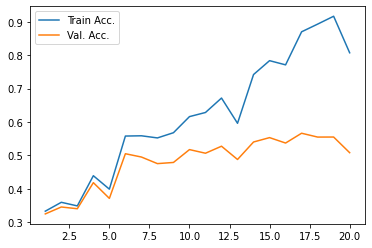

In [38]:
plt.plot(list(range(1, 21)), [float(train_acc) for train_acc in results["train_acc"]], label="Train Acc.")
plt.plot(list(range(1, 21)), [float(val_acc) for val_acc in results["val_acc"]], label="Val. Acc.")
plt.legend()
plt.show()

Clearly, there's some overfit, especially after 12-15 epochs, where validation accuracy begins to flatten. However, a key result to notice is that the accuracy doesn't start from 0.10, which would correspond to the model picking a random class out of the 10 options; instead, the accuracy starts from 0.3 and above, indicating that even after just 1 epoch of training BYOL, it managed to learn the representations of the images. This indicates that it is an effective self-supervised technique for learning image representations.